# Resonance frequencies of a metal cylindrical cantilever

Here we explore a practical example of importing and analyzing data taken from an oscilloscope (in this case, Instek GDS-1052-U 50MHz Digital Oscilloscope 2CH). We make use of the fast Fourier transform (FFT) algorithm from the numpy library to learn about the natural frequencies that a cantilever ("diving board") makes when perturbed.

What happens here:
* import data from csv file
* select a range of interest (ROI) by user-defined start and stop times
* plot ROI for confirmation
* fast Fourier transform (FFT) of ROI
* save FFT result as a data file

This can be repeated for several files, then we explore the dependence of the resonance frequency on lengths:
* show FFT for multiple analyzed files
* analyze spectrum -- e.g., find peak position (, estimate Q-factor)
* estimate Young's modulus for the material based on geometry, density, and resonance frequency dependence
* estimate fundamental resonance frequency using a formula

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.optimize
%matplotlib inline

In [2]:
# user-modified area:
filename= 'DS0004.csv'

In [3]:
# import data from csv file
data = np.genfromtxt(filename,delimiter=',',skip_header=17 )
x_values = data[:,0]
y_values = data[:,1]

Just a simple plot of the imported data, no fancy things like axis labels or legends (we'll do that in a moment). The 'x-axis' is time, in seconds.

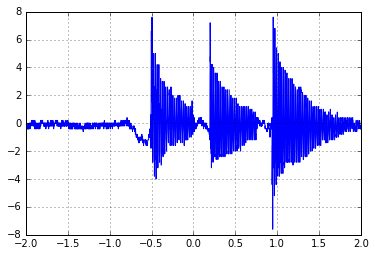

In [4]:
plt.plot(x_values, y_values)
plt.grid()
plt.show()

Define the range of interest (ROI) by defining start and stop times that you are interested in analyzing:

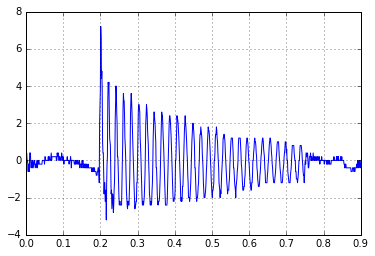

In [5]:
# start_time, stop_time = 0.9, 1.9
start_time, stop_time = 0,.9

start_time_idx = np.where(x_values > start_time)[0][0]
stop_time_idx = np.where(x_values > stop_time)[0][0]
x_ROI = x_values[start_time_idx:stop_time_idx]
y_ROI = y_values[start_time_idx:stop_time_idx]

plt.plot(x_ROI,y_ROI)
plt.grid()
plt.show()
# uncomment the following line to save the image as a *.png file:
# plt.savefig('range of interest.png',dpi=400)

Next we perform the fast Fourier transform (FFT) on data in the ROI do find out the frequency content of this waveform.

In [6]:
Y_FFT = np.fft.fft(y_ROI)
y2 = Y_FFT * np.conjugate(Y_FFT)
pow = abs(y2[1:len(Y_FFT)//2] + y2[:len(Y_FFT)//2:-1])
DT = x_ROI[1]-x_ROI[0]   # sample time
freq = (np.fft.fftfreq(x_ROI.shape[0])/DT)[1:len(Y_FFT)//2]

Plotting the power spectrum -- sometimes a semilogarithmic plot helps us to see smaller features easier -- in this case, harmonics arise because this metal cylinder is not perfect, meaning that the oscillation is not a perfect dampened sinusoidal wave.

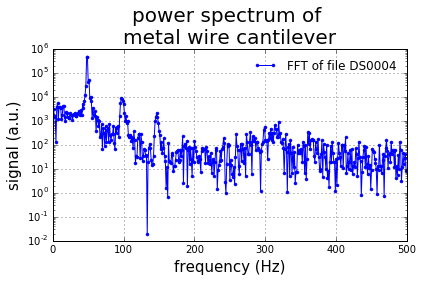

In [7]:
title = 'power spectrum of \nmetal wire cantilever'
xaxis_label = 'frequency (Hz)'
yaxis_label = 'signal (a.u.)'

plt.semilogy(freq,pow,'.-',label='FFT of file '+filename[0:6])

plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.grid()
plt.title(title,fontsize=20)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

# plt.xlim([0,400])
plt.legend(frameon=False,loc='best') 
plt.tight_layout() 

# save the figure as a png file. It will be saved to the same directory as your program.
# plt.savefig('mydata.png',dpi=400)

# save the analyzed data to a text file with a name corresponding to the original filename
np.savetxt('FFT_'+filename[0:6]+'.txt', (freq,pow), delimiter=',',fmt='%.4e')

This concludes the analysis for each file individually. This can be repeated for multiple files, carefully choosing a new ROI each time, and FFT files will be saved. These files can then be compared and analyzed with the following code:

In [8]:
# list the filenames 
file_number_max_idx = 5
filenames = ['DS{:04d}'.format(x) for x in range(file_number_max_idx)]

In [9]:
# this is a procedural approach

fft_data = {}

for filename in filenames:
    data = np.genfromtxt('FFT_{}.txt'.format(filename),
                         delimiter=',',unpack=True)
    fft_data[filename] = (data[:,0], data[:,1])
    

In [10]:
# this is a functional approach -- less prone to errors!

def load_data(filename):
    data = np.genfromtxt('FFT_{}.txt'.format(filename),
                         delimiter=',',unpack=True)
    return {'fft_x':data[:,0], 'fft_y':data[:, 1]}

fft_data = {filename:load_data(filename) for filename in filenames}

In [11]:
fft_data.keys()

dict_keys(['DS0000', 'DS0001', 'DS0002', 'DS0003', 'DS0004'])

In [12]:
# fft_data['DS0000']['fft_x']

Now we have plotted the FFT data for multiple frequencies. Let's try finding the peaks for each and confirm on the plot that we have found the peak for each:

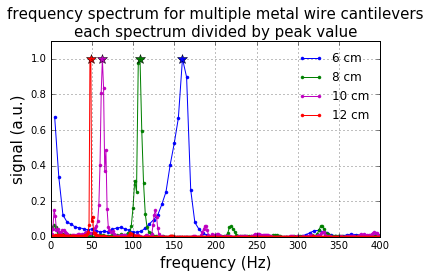

In [13]:
title = 'frequency spectrum for multiple metal wire cantilevers\neach spectrum divided by peak value'
xaxis_label = 'frequency (Hz)'
yaxis_label = 'signal (a.u.)'

data_dict = {1:{'length':6,'color':'b'},
              2:{'length':8,'color':'g'},
              3:{'length':10,'color':'m'},
              4:{'length':12,'color':'r'}}

# this is because we don't want to count the DC offset value as the peak...
begin_spectrum_analyze_idx = 3

for key,meta in data_dict.items():
    filename = 'DS{:04d}'.format(key)
    fft_x = fft_data[filename]['fft_x']
    fft_y = fft_data[filename]['fft_y']
    # divide by max so FFT data can be displayed on same scale
    fft_y = fft_y/np.max(fft_y)
    max_index = fft_y[begin_spectrum_analyze_idx:].argmax()+begin_spectrum_analyze_idx
    meta['resonance_freq'] = fft_x[max_index]
    plt.plot(fft_x,fft_y,'.-',
             label='{} cm'.format(meta.get('length')),color=meta.get('color'))
    plt.plot(fft_x[max_index],fft_y[max_index],'*',markersize=10,color=meta.get('color'))

plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.grid()
plt.title(title,fontsize=15)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

plt.legend(frameon=False,loc='best') 
plt.xlim([0,400])
plt.ylim([1e-5,1.1])
plt.tight_layout() 

# save the figure as a png file. It will be saved 
# to the same directory as your program.
plt.savefig('cantilever fft data.png',dpi=400)

This trend is more or less how we'd expect: longer cantilevers oscillate at lower frequencies. Like Hooke's law: more mass, lower resonance. Let's go a layer deeper and see whether the length scales as 1/length^2...

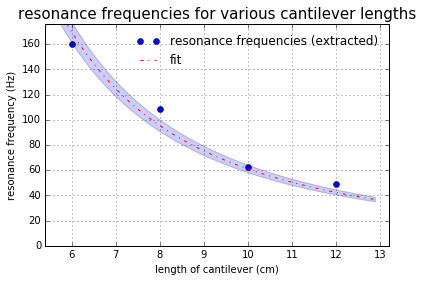

In [14]:
lengths = [v['length'] for k,v in data_dict.items()]
lengths = np.asarray(lengths)

freqs = [meta['resonance_freq'] for key,meta in data_dict.items()]

def inv_sq_fn(L,param_weight):
    return (param_weight/L**2)

# guess to help the process of finding
# p_guess = [6000]
# p_vals, p_cov = scipy.optimize.curve_fit(inv_sq_fn, lengths, freqs, p0 = p_guess)

p_vals, p_cov = scipy.optimize.curve_fit(inv_sq_fn, lengths, freqs)
perr = np.sqrt(np.diag(p_cov))

plt.plot(lengths,freqs,'o',label='resonance frequencies (extracted)')

xaxis = np.arange(1,13,0.1)
plt.plot(xaxis, inv_sq_fn(xaxis, p_vals), '-.r',label='fit')
plt.fill_between(xaxis, inv_sq_fn(xaxis, p_vals+perr), inv_sq_fn(xaxis, p_vals-perr), facecolor='blue', alpha=0.2)
plt.grid()
plt.xlim([min(lengths)*.9,max(lengths)*1.1])
plt.ylim([0,max(freqs)*1.1])
plt.xlabel('length of cantilever (cm)')
plt.ylabel('resonance frequency (Hz)')
plt.title('resonance frequencies for various cantilever lengths',fontsize=15)
plt.legend(frameon=False,loc='best') 
plt.tight_layout()

In [15]:
#[6500/L**2 for L in lengths]
# [sum(f - g/l**2 for f, l in zip(freqs, lengths)) for g in [6250, 6260, 6270, 6280, 6290]]

Here's another (inferior) method of getting at the coefficient -- but this method is not as good because we are imagining a model with an offset, and there should *not* be any offset for the equation frequency = const. * 1/L^2

(this way considers frequency = c0 * 1/L^2 + c1)

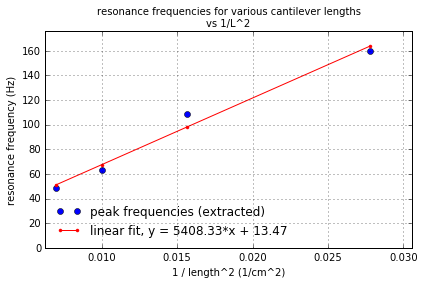

In [16]:
length_inv_sqrd = [L**(-2) for L in lengths]
length_inv_sqrd = np.asarray(length_inv_sqrd)
p = np.polyfit(length_inv_sqrd,freqs,1)   # these are the polynomial coefficients for a linear-order polyomial
m = p[0]
b = p[1]
yfit = m*length_inv_sqrd + b    # constructing the array for the polynomial fit curve

plt.plot(length_inv_sqrd,freqs,'o',label='peak frequencies (extracted)')
plt.plot(length_inv_sqrd,yfit,'.-r',label='linear fit, y = %2.2f*x + %2.2f'%(m,b))
plt.grid()
plt.xlim([np.min(length_inv_sqrd)*.9,np.max(length_inv_sqrd)*1.1])
plt.ylim([0,np.max(freqs)*1.1])
plt.xlabel('1 / length^2 (1/cm^2)')
plt.ylabel('resonance frequency (Hz)')
plt.legend(frameon=False,loc='best') 
plt.title('resonance frequencies for various cantilever lengths\nvs 1/L^2',fontsize=10)
plt.tight_layout() 

Using a formula from this reference for the resonance frequencies of a cantilever:

http://iitg.vlab.co.in/?sub=62&brch=175&sim=1080&cnt=1

Exercises for students:
* input coefficient from fit (freq vs 1/length^2), diameter, and density --> output Young's modulus
* prediction of next resonance frequency

In [17]:
# input parameters:
d = .9e-3      # diameter of metal cylinder (m)
L = 10e-2     # length of cylinder (m)

# E = 0.69e11  # N/m^2   value for aluminum
# rho = 2700  # kg/m^3

E = 2.1e11  # N/m^2   value for steel
rho = 7850  # kg/m^3

I=np.pi/64*d**4   # moment of inertial of cross-section -- defined in terms of d
A = np.pi*(d/2)**2  # cross-sectional area -- defined in terms of d

# first few resonance frequencies -- note, NOT harmonic!
def freq1(E,I,rho,L):
    return 1.875**2 * (1/(2*np.pi))* np.sqrt(E*I/(rho*A*L**4))
def freq2(E,I,rho,L):
    return 4.694**2 * (1/(2*np.pi))* np.sqrt(E*I/(rho*A*L**4))
def freq3(E,I,rho,L):
    return 7.855**2 * (1/(2*np.pi))* np.sqrt(E*I/(rho*A*L**4))
print("Estimated resonance frequencies for a %.1f cm cantilever"%(L*100))
print("Fundamental: %.2f Hz"%(freq1(E,I,rho,L)))
print("Second: %.2f Hz"%(freq2(E,I,rho,L)))
print("Third: %.2f Hz"%(freq3(E,I,rho,L)))

Estimated resonance frequencies for a 10.0 cm cantilever
Fundamental: 65.11 Hz
Second: 408.10 Hz
Third: 1142.80 Hz


In [18]:
freqs, lengths

([160.0, 108.51000000000001, 62.856999999999999, 48.889000000000003],
 array([ 6,  8, 10, 12]))

In [19]:
# Approaching the problem from the other way around -- using my "fit" from above to define 
def youngs_modulus(A,rho,I,weight_param):
    return (weight_param/10**4/(1.875**2/(2*np.pi)*np.sqrt(I/(rho*A))))**2

print("first method: curve fit (weight_param/L^2)")
print("Young's modulus = %2.2e N/m^2"%(youngs_modulus(A,rho,I,6280)))
print("ratio of this value to 'book' value for steel = %.2f"%(youngs_modulus(A,rho,I,6280)/E))
print("")
print("second method (linear fit with offset possible):")
print("Young's modulus = %2.2e N/m^2"%(youngs_modulus(A,rho,I,m)))
print("ratio of this value to 'book' value for steel = %.2f"%(youngs_modulus(A,rho,I,m)/E))


first method: curve fit (weight_param/L^2)
Young's modulus = 1.95e+11 N/m^2
ratio of this value to 'book' value for steel = 0.93

second method (linear fit with offset possible):
Young's modulus = 1.45e+11 N/m^2
ratio of this value to 'book' value for steel = 0.69


The last part to explore is whether there is actually a second resonance frequency peak that shows up in the data. For the higher frequency data it's not going to be possible to see this because the sampling rate of the scope (1 kHz <--> 1 ms) limits the highest frequency we can perceive. The next fundamental frequency should be ~6.3 times the fundamental. But for the 12 cm cantilever, the fundamental frequency is 48.9 Hz. There are some harmonics, but these are not the same as the different bending modes in the cantilever (as depicted in the weblink above).  This corresponds to 306 Hz -- which can be seen as a small (yet broad) peak in a semilogy plot for the 12 cm cantilever.

In [20]:
f_second = 48.889000000000003 * 4.694**2 / 1.875**2
f_second

306.40424687047107

In [21]:
4.694**2 / 1.875**2

6.267345351111111

In [22]:
DT**-1

1000.0

Thoughts for future work:
* many smartphone cameras offer up to 240 fps recording -- this is enough to observe the fundamental frequency of a ~10-12cm cantilever. The sound recording might work too with one of the o-scope apps
* improving the precision / sensistivity of the measurement -- this was a *very* basic measurement